<a href="https://colab.research.google.com/github/emmayeh-0211/Team-Topic/blob/main/%E5%B0%88%E9%A1%8C_%E9%A6%99%E8%95%89SVR_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# 掛載google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


index：日期
input data：批發市場交易量、每日天氣、颱風警報
output answer：批發市場每日交易價格

In [12]:
import pandas as pd
from IPython.display import display
# 資料來自個地方
w_file_path = '/content/drive/MyDrive/Ai團專_農時_共享資料夾/Dataset_資料集/氣候資料/各縣市氣候資料_0701/dataset.csv'
p_file_path = '/content/drive/MyDrive/Ai團專_農時_共享資料夾/Dataset_資料集/市場批發交易歷史資料/Banana.csv'
weather_df = pd.read_csv(w_file_path) # 氣候資料
weather_df.set_index(["date"], inplace=True)
price_df = pd.read_csv(p_file_path) # 香蕉的批發交易資料
filter = price_df.Market == '台北一' # 篩選出只有台北一的批發交易資料
price_df = price_df[filter]
price_df.set_index(["Date"], inplace=True)
display(weather_df.tail())
display(price_df.tail())


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (130,132,305,307) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,city_KLU,StnPres_KLU,SeaPres_KLU,StnPresMax_KLU,StnPresMaxTime_KLU,StnPresMin_KLU,StnPresMinTime_KLU,Temperature_KLU,TMax_KLU,TMaxTime_KLU,TMin_KLU,TMinTime_KLU,TdDewPoint_KLU,RH_KLU,RHMin_KLU,RHMinTime_KLU,WS_KLU,WD_KLU,WSGust_KLU,WDGust_KLU,WGustTime_KLU,Precp_KLU,PrecpHour_KLU,PrecpMax10_KLU,PrecpMax10Time_KLU,PrecpMax60_KLU,PrecpMax60Time_KLU,SunShine_KLU,SunShineRate_KLU,GloblRad_KLU,VisbMean_KLU,EvapA_KLU,UVIMax_KLU,UVIMaxTime_KLU,CloudAmount_KLU,city_TPE,StnPres_TPE,SeaPres_TPE,StnPresMax_TPE,StnPresMaxTime_TPE,...,EvapA_HWA,UVIMax_HWA,UVIMaxTime_HWA,CloudAmount_HWA,city_TTT,StnPres_TTT,SeaPres_TTT,StnPresMax_TTT,StnPresMaxTime_TTT,StnPresMin_TTT,StnPresMinTime_TTT,Temperature_TTT,TMax_TTT,TMaxTime_TTT,TMin_TTT,TMinTime_TTT,TdDewPoint_TTT,RH_TTT,RHMin_TTT,RHMinTime_TTT,WS_TTT,WD_TTT,WSGust_TTT,WDGust_TTT,WGustTime_TTT,Precp_TTT,PrecpHour_TTT,PrecpMax10_TTT,PrecpMax10Time_TTT,PrecpMax60_TTT,PrecpMax60Time_TTT,SunShine_TTT,SunShineRate_TTT,GloblRad_TTT,VisbMean_TTT,EvapA_TTT,UVIMax_TTT,UVIMaxTime_TTT,CloudAmount_TTT,WarnMark
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-14,基隆市,997.3,1005.4,999.9,2021-06-14 00:01:00,995.3,2021-06-14 15:33:00,29.6,34.1,2021-06-14 14:15:45,27.3,2021-06-14 03:40:30,26.1,79.8,58.8,2021-06-14 12:36:45,4.7,173.2,13.6,253.0,2021-06-14 10:10:15,0.0,0.0,0.0,NaN,0.0,NaN,8.7,63.7,24.9,31.0,7.4,13.0,2021-06-14 13:00:00,7.5,臺北市,978.9,1164.5,981.5,2021-06-14 03:00:42,...,5.2,13.0,2021-06-14 12:00:00,4.1,臺東縣,966.7,1005.6,969.3,2021-06-14 00:01:25,964.9,2021-06-14 16:40:08,27.2,31.5,2021-06-14 12:35:50,23.8,2021-06-14 04:34:13,25.7,83.9,62.6,2021-06-14 11:24:30,1.6,139.8,7.4,172.0,2021-06-14 13:48:07,0.0,0.0,0.0,NaN,0.0,NaN,10.3,75.8,26.8,23.5,5.8,13.3,2021-06-14 12:40:00,4.5,0
2021-06-15,基隆市,994.7,1002.9,995.9,2021-06-15 00:01:00,993.5,2021-06-15 12:51:00,30.2,33.5,2021-06-15 13:34:45,27.6,2021-06-15 08:42:00,26.0,76.2,62.8,2021-06-15 11:08:00,6.1,231.2,16.5,253.0,2021-06-15 06:39:15,0.0,0.0,0.0,NaN,0.0,NaN,10.9,79.5,27.3,30.6,7.9,13.0,2021-06-15 12:00:00,7.2,臺北市,976.6,1156.6,977.9,2021-06-15 08:28:14,...,6.7,13.0,2021-06-15 13:00:00,4.1,臺東縣,964.6,1003.2,966.3,2021-06-15 12:02:27,963.3,2021-06-15 10:16:10,27.5,32.1,2021-06-15 11:59:22,24.2,2021-06-15 08:52:37,25.4,79.9,59.2,2021-06-15 10:56:33,2.0,148.6,9.4,166.6,2021-06-15 11:59:30,0.0,0.0,0.0,NaN,0.0,NaN,10.6,78.2,26.0,25.3,6.2,12.7,2021-06-15 12:00:00,5.2,0
2021-06-16,基隆市,995.4,1003.5,997.0,2021-06-16 21:56:30,993.4,2021-06-16 02:18:00,31.0,34.4,2021-06-16 15:19:15,27.7,2021-06-16 02:22:45,25.1,68.8,53.5,2021-06-16 15:40:00,8.7,248.8,20.4,260.2,2021-06-16 13:01:15,0.0,0.0,0.0,NaN,0.0,NaN,11.5,84.2,28.6,29.6,10.3,14.0,2021-06-16 12:00:00,2.8,臺北市,977.7,1161.4,979.4,2021-06-16 18:40:42,...,7.7,13.0,2021-06-16 12:00:00,1.9,臺東縣,965.4,1004.2,967.5,2021-06-16 21:56:45,963.5,2021-06-16 05:06:48,28.3,33.2,2021-06-16 12:44:23,24.1,2021-06-16 03:53:27,24.4,72.7,51.6,2021-06-16 13:24:10,2.3,166.5,10.4,194.7,2021-06-16 12:31:57,0.0,0.0,0.0,NaN,0.0,NaN,10.8,79.8,27.8,24.1,7.4,13.0,2021-06-16 12:20:00,4.4,0
2021-06-17,基隆市,996.9,1005.0,998.2,2021-06-17 08:58:15,995.5,2021-06-17 09:14:45,31.1,35.2,2021-06-17 13:44:00,28.0,2021-06-17 05:22:45,25.3,68.8,54.8,2021-06-17 14:04:00,7.9,233.2,18.1,243.2,2021-06-17 06:48:15,0.0,0.0,0.0,NaN,0.0,NaN,11.1,81.3,26.2,23.9,8.6,13.0,2021-06-17 12:00:00,5.8,臺北市,979.0,1166.5,980.5,2021-06-17 08:18:46,...,6.1,13.0,2021-06-17 12:00:00,1.5,臺東縣,966.8,1005.4,968.2,2021-06-17 20:23:43,965.5,2021-06-17 14:22:05,28.4,33.0,2021-06-17 12:45:47,24.9,2021-06-17 10:27:33,24.5,72.5,52.4,2021-06-17 12:09:22,2.0,164.5,9.0,151.5,2021-06-17 14:03:52,0.0,0.0,0.0,NaN,0.0,NaN,10.2,75.2,27.2,25.0,7.2,13.0,2021-06-17 12:00:00,2.5,0
2021-06-18,基隆市,995.5,1003.6,997.1,2021-06-18 03:47:30,993.5,2021-06-18 15:39:30,31.3,35.4,2021-06-18 13:46:15,28.4,2021-06-18 03:33:15,25.4,68.0,50.5,2021-06-18 13:44:45,8.0,232.5,18.7,239.8,2021-06-18 07:33:30,0.0,0.0,0.0,NaN,0.0,NaN,10.3,75.5,26.6,25.8,9.2,14.0,2021-06-18 12:00:0

,Market,Product,Up_price,Mid_price,Low_price,Avg_price,Volume,Month,Week_day,Year,Rest_day
Date,,,,,,,,,,,
2021-06-15,台北一,A1 香蕉,NaN,NaN,NaN,NaN,NaN,6,2,2021,1
2021-06-16,台北一,A1 香蕉,NaN,NaN,NaN,NaN,NaN,6,3,2021,1
2021-06-17,台北一,A1 香蕉,32.5,23.4,13.3,23.2,18276.0,6,4,2021,0
2021-06-18,台北一,A1 香蕉,30.9,20.4,12.1,20.9,14040.0,6,5,2021,0
2021-06-19,台北一,A1 香蕉,33.4,25.5,14.0,24.8,13485.0,6,6,2021,0


In [13]:
# 天氣欄位太多，因此只保留 氣溫、最高溫、最低溫、風速、最大風速、雨量 這6個因素
# 縣市只挑選香蕉主要產地：高雄、屏東、南投 3個縣市
factors = ['Temperature', 'T_Max', 'T_Min', 'WS_', 'WSGust', 'Precp_']
citys = ['KHH', 'IUH', 'NTO']
keep = ['WarnMark']
for c in citys:
  for w in weather_df:
    if c in w:
      for f in factors:
        if f in w:
          keep.append(w)
weather_df = weather_df.loc[:, keep]
weather_df.tail()

,WarnMark,Temperature_KHH,WS_KHH,WSGust_KHH,Precp_KHH,Temperature_IUH,WS_IUH,WSGust_IUH,Precp_IUH,Temperature_NTO,WS_NTO,WSGust_NTO,Precp_NTO
date,,,,,,,,,,,,,
2021-06-14,0,29.4,1.6,7.5,0.1,28.2,2.7,10.1,0.4,22.6,1.6,7.4,0.4
2021-06-15,0,29.0,1.3,6.2,5.2,27.7,2.4,9.7,4.9,22.8,1.7,7.7,0.7
2021-06-16,0,27.3,1.3,7.4,26.7,26.6,2.9,11.5,30.1,21.2,1.8,7.6,12.2
2021-06-17,0,27.9,1.3,7.0,9.0,27.4,2.8,11.0,5.3,21.9,1.8,7.7,4.5
2021-06-18,0,28.2,1.2,7.1,10.9,27.7,2.9,11.3,4.3,22.3,1.8,7.5,1.4


In [14]:
# 將市場資料中的 價格及交易量空值補上0
values = {'Up_price':0, 'Mid_price':0, 'Low_price':0, 'Avg_price':0, 'Volume':0}
price_df = price_df.fillna(value=values)
price_df

,Market,Product,Up_price,Mid_price,Low_price,Avg_price,Volume,Month,Week_day,Year,Rest_day
Date,,,,,,,,,,,
2000-01-02,台北一,A1 香蕉,30.0,22.0,14.0,20.2,22319.0,1,7,2000,0
2000-01-03,台北一,A1 香蕉,26.0,18.0,12.0,19.5,15810.0,1,1,2000,0
2000-01-04,台北一,A1 香蕉,28.0,18.0,12.0,20.3,15126.0,1,2,2000,0
2000-01-05,台北一,A1 香蕉,28.0,20.0,10.0,20.0,18693.0,1,3,2000,0
2000-01-06,台北一,A1 香蕉,28.0,20.0,10.0,20.3,22677.0,1,4,2000,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-06-15,台北一,A1 香蕉,0.0,0.0,0.0,0.0,0.0,6,2,2021,1
2021-06-16,台北一,A1 香蕉,0.0,0.0,0.0,0.0,0.0,6,3,2021,1
2021-06-17,台北一,A1 香蕉,32.5,23.4,13.3,23.2,18276.0,6,4,2021,0


In [15]:
# 合併 天氣因素表格&批發市場價格表格
new_df = pd.merge(weather_df, price_df, how='outer', left_index=True, right_index=True)
new_df = new_df[1: -1] # 2020.01.01 市場交易沒資料，跟最後一筆沒有天氣資料，所以用slice方式拿掉
display(new_df.head())
display(new_df.tail())

,WarnMark,Temperature_KHH,WS_KHH,WSGust_KHH,Precp_KHH,Temperature_IUH,WS_IUH,WSGust_IUH,Precp_IUH,Temperature_NTO,WS_NTO,WSGust_NTO,Precp_NTO,Market,Product,Up_price,Mid_price,Low_price,Avg_price,Volume,Month,Week_day,Year,Rest_day
2000-01-02,0.0,21.0,1.7,5.8,0.0,21.1,3.3,13.3,0.0,8.3,6.5,13.1,0.0,台北一,A1 香蕉,30.0,22.0,14.0,20.2,22319.0,1.0,7.0,2000.0,0.0
2000-01-03,0.0,20.6,1.8,7.0,0.0,20.7,2.9,13.0,0.1,6.3,6.4,14.8,0.0,台北一,A1 香蕉,26.0,18.0,12.0,19.5,15810.0,1.0,1.0,2000.0,0.0
2000-01-04,0.0,20.8,1.9,6.5,0.1,20.8,2.2,9.2,0.0,5.7,6.1,12.3,0.0,台北一,A1 香蕉,28.0,18.0,12.0,20.3,15126.0,1.0,2.0,2000.0,0.0
2000-01-05,0.0,22.4,1.6,4.9,0.2,22.4,1.5,5.8,0.0,6.9,4.0,13.2,0.0,台北一,A1 香蕉,28.0,20.0,10.0,20.0,18693.0,1.0,3.0,2000.0,0.0
2000-01-06,0.0,21.9,1.2,4.9,0.1,21.9,2.4,10.1,1.6,7.1,4.8,12.0,0.0,台北一,A1 香蕉,28.0,20.0,10.0,20.3,22677.0,1.0,4.0,2000.0,0.0


,WarnMark,Temperature_KHH,WS_KHH,WSGust_KHH,Precp_KHH,Temperature_IUH,WS_IUH,WSGust_IUH,Precp_IUH,Temperature_NTO,WS_NTO,WSGust_NTO,Precp_NTO,Market,Product,Up_price,Mid_price,Low_price,Avg_price,Volume,Month,Week_day,Year,Rest_day
2021-06-14,0.0,29.4,1.6,7.5,0.1,28.2,2.7,10.1,0.4,22.6,1.6,7.4,0.4,台北一,A1 香蕉,33.3,26.6,19.8,26.6,15039.0,6.0,1.0,2021.0,0.0
2021-06-15,0.0,29.0,1.3,6.2,5.2,27.7,2.4,9.7,4.9,22.8,1.7,7.7,0.7,台北一,A1 香蕉,0.0,0.0,0.0,0.0,0.0,6.0,2.0,2021.0,1.0
2021-06-16,0.0,27.3,1.3,7.4,26.7,26.6,2.9,11.5,30.1,21.2,1.8,7.6,12.2,台北一,A1 香蕉,0.0,0.0,0.0,0.0,0.0,6.0,3.0,2021.0,1.0
2021-06-17,0.0,27.9,1.3,7.0,9.0,27.4,2.8,11.0,5.3,21.9,1.8,7.7,4.5,台北一,A1 香蕉,32.5,23.4,13.3,23.2,18276.0,6.0,4.0,2021.0,0.0
2021-06-18,0.0,28.2,1.2,7.1,10.9,27.7,2.9,11.3,4.3,22.3,1.8,7.5,1.4,台北一,A1 香蕉,30.9,20.4,12.1,20.9,14040.0,6.0,5.0,2021.0,0.0


In [16]:
# 另外因為只有針對單一市場跟作物，因此不需要 Market 跟 Product 兩個欄位了，使用drop方式移除
# 另外應該也不能放上中下價，也先移除
new_df = new_df.drop(columns=['Market', 'Product', 'Up_price', 'Mid_price', 'Low_price'])
display(new_df.head())
display(new_df.tail())

,WarnMark,Temperature_KHH,WS_KHH,WSGust_KHH,Precp_KHH,Temperature_IUH,WS_IUH,WSGust_IUH,Precp_IUH,Temperature_NTO,WS_NTO,WSGust_NTO,Precp_NTO,Avg_price,Volume,Month,Week_day,Year,Rest_day
2000-01-02,0.0,21.0,1.7,5.8,0.0,21.1,3.3,13.3,0.0,8.3,6.5,13.1,0.0,20.2,22319.0,1.0,7.0,2000.0,0.0
2000-01-03,0.0,20.6,1.8,7.0,0.0,20.7,2.9,13.0,0.1,6.3,6.4,14.8,0.0,19.5,15810.0,1.0,1.0,2000.0,0.0
2000-01-04,0.0,20.8,1.9,6.5,0.1,20.8,2.2,9.2,0.0,5.7,6.1,12.3,0.0,20.3,15126.0,1.0,2.0,2000.0,0.0
2000-01-05,0.0,22.4,1.6,4.9,0.2,22.4,1.5,5.8,0.0,6.9,4.0,13.2,0.0,20.0,18693.0,1.0,3.0,2000.0,0.0
2000-01-06,0.0,21.9,1.2,4.9,0.1,21.9,2.4,10.1,1.6,7.1,4.8,12.0,0.0,20.3,22677.0,1.0,4.0,2000.0,0.0


,WarnMark,Temperature_KHH,WS_KHH,WSGust_KHH,Precp_KHH,Temperature_IUH,WS_IUH,WSGust_IUH,Precp_IUH,Temperature_NTO,WS_NTO,WSGust_NTO,Precp_NTO,Avg_price,Volume,Month,Week_day,Year,Rest_day
2021-06-14,0.0,29.4,1.6,7.5,0.1,28.2,2.7,10.1,0.4,22.6,1.6,7.4,0.4,26.6,15039.0,6.0,1.0,2021.0,0.0
2021-06-15,0.0,29.0,1.3,6.2,5.2,27.7,2.4,9.7,4.9,22.8,1.7,7.7,0.7,0.0,0.0,6.0,2.0,2021.0,1.0
2021-06-16,0.0,27.3,1.3,7.4,26.7,26.6,2.9,11.5,30.1,21.2,1.8,7.6,12.2,0.0,0.0,6.0,3.0,2021.0,1.0
2021-06-17,0.0,27.9,1.3,7.0,9.0,27.4,2.8,11.0,5.3,21.9,1.8,7.7,4.5,23.2,18276.0,6.0,4.0,2021.0,0.0
2021-06-18,0.0,28.2,1.2,7.1,10.9,27.7,2.9,11.3,4.3,22.3,1.8,7.5,1.4,20.9,14040.0,6.0,5.0,2021.0,0.0


In [17]:
# sklearn前：pandas.DataFrame
# sklearn後：np.array
import numpy as np
from sklearn.model_selection import train_test_split
x, y = np.array(new_df.drop(['Avg_price'], axis=1)), np.array(new_df['Avg_price'])
# 90% x, 10% x, 90% y, 10% y）
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.1)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(7055, 18)
(784, 18)
(7055,)
(784,)


In [18]:
# 使用SVR演算法訓練模型
from sklearn.svm import SVR
clf = SVR(kernel='rbf', C=1e3, gamma=0.1)

In [19]:
clf.fit(x_train, y_train) # 餵資料給模型

SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

https://zhuanlan.zhihu.com/p/24779083
https://machine-learning-python.kspax.io/application/svr

In [20]:
# import matplotlib.pyplot as plt
# _, ax = plt.subplots(figsize=[14, 7])
# ax.scatter(x_train, y_train, c='#F61909', label='data')
# ax.plot(x_train, y_rbf, c='#486DDB', label='RBF model')
# ticks = ax.get_xticks()
# plt.xlabel('data')
# plt.ylabel('price')
# plt.title('SVR')
# plt.legend()
# plt.show()

score: 0.17947272020161842


Text(0, 0.5, 'Measured')

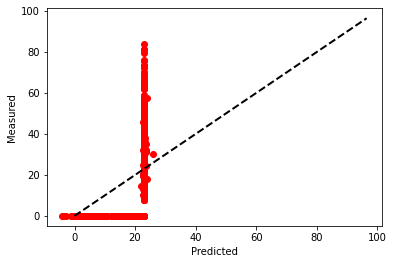

In [26]:
predict_y_test=clf.predict(x_test)
predict=clf.predict(x_train)
score = clf.score(x_test, y_test)
print('score:', score)
# plt.scatter(predict,y_train,s=2)
plt.plot(predict_y_test, y_test, 'ro')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.xlabel('Predicted')
plt.ylabel('Measured')